In [1]:
import networkx as nx
import numpy as np
import torch
from torch.nn import Parameter
import matplotlib.pyplot as plt
import random 
import math
import pandas as pd

# Functions

In [14]:
def hid_var_dag(latent=2,observed=5,dag_type = 'default',parents_max = 3,
                expected_degree=3):
    
    """
        Generate random Directed Acyclic Graphs (DAGs) with hidden variables.
        
        Parameters:
        - latent (int): Number of hidden variables.
        - observed (int): Number of observed variables.
        - dag_type (str): Type of DAG to generate ('default' or 'erdos').
        - parents_max (int): Maximum number of parents for observed variables in the 'default' DAG type.
        - expected_degree (int): Expected degree of nodes in the 'erdos' DAG type.
        
        Returns:
        - g (nx.DiGraph): Generated DAG as a NetworkX DiGraph object.
        
    """
    
    adj = np.zeros((latent+observed, latent+observed))
    for i in range(latent):
        obs_ch = np.random.randint(latent,latent+observed,np.random.randint(2,observed+1))
        for j in obs_ch:
            adj[i,j] = 1;
            
    if dag_type == 'default':
        for j in range(1, observed):
            nb_parents = np.random.randint(0, min([parents_max, j])+1)
            for i in np.random.choice(range(0, j), nb_parents, replace=False):
                adj[latent+i,latent+j] = 1

    elif dag_type == 'erdos':
        nb_edges = expected_degree * observed
        prob_connection = 2 * nb_edges/(observed**2 - observed)
        causal_order = np.random.permutation(np.arange(observed))

        for i in range(observed - 1):
            node = causal_order[i]
            possible_parents = causal_order[(i+1):]
            num_parents = np.random.binomial(n=observed - i - 1,
                                             p=prob_connection)
            parents = np.random.choice(possible_parents, size=num_parents,
                                       replace=False)
            adj[latent+parents,latent+node] = 1      
            
    g = nx.DiGraph(adj)            
    return g



def hid_var_data(latent=2,observed=5,g = None, n = 500, 
                 withening = True, distr = 'Laplace', same_var = True):
    """
    Generate, possibly whitened, data from a given DAG.
    
    Parameters:
        - latent (int): Number of hidden variables.
        - observed (int): Number of observed variables.
        - g (nx.DiGraph): The DAG as a NetworkX DiGraph object.
        - n (int): Number of data samples to generate.
        - withening (bool): Flag to apply whitening to the data.
        - distr(string): 'Laplace' or 'Cauchy'
        - same_var(bool): True if the noise terms must have the same variance
    
    Returns:
        - data (torch.Tensor): Generated data.
        - adj (torch.Tensor): Adjacency matrix of the DAG.
        - W_with (torch.Tensor): Whitening matrix (if applicable otherwise identity matrix).
        - weight (torch.Tensor): Weights associated with the DAG edges.
    
    """
    weight =torch.Tensor(len(g.edges())).normal_(0,10)
    
    adj = torch.eye(len(g.nodes()))
    for e in range(len(g.edges())):
        adj[list(g.edges)[e]]=-weight[e]
    B = (torch.inverse(adj)).t()

    
    err = torch.Tensor(latent+observed,n)
    
    for j in range(latent+observed):
        if same_var == 'True':
            varr = 1
        else:
            varr = torch.Tensor(1).uniform_(0.2,10)
        for i in range(n):
            if distr == 'Laplace':
                err[j,i] = torch.distributions.laplace.Laplace(0,1).sample()*varr
            elif distr == 'Cauchy ':
                err[j, i] = torch.Tensor(1).cauchy_()*varr
            else:
                raise("'Distr' has to be either 'Laplace' of 'Cauchy'") 
                

    
    err = torch.Tensor(latent+observed,n).cauchy_()
    data = B.matmul(err).t()
    data = data[:,range(latent, observed+latent)]
    d_cov = (data.t()).cov()
    
    if withening == True:
        U, S, V = d_cov.svd()
        S_2=torch.inverse(torch.diag(S.sqrt()))
        W_with = S_2.matmul(V.t())
        data = W_with.matmul(data.t()).t()
        
        return data, adj, W_with, weight
    
    return data, adj,torch.eye(observed) ,weight


def init_w_guess(data, g, latent, observed, W_with):
    up_data = W_with.inverse().matmul(data.t())
    w = torch.zeros(len(g.edges()))
    mask = torch.zeros(len(g.edges()))

    for i, e in enumerate(g.edges()):
        if e[0] < latent:
            w[i] = torch.Tensor(1).normal_().item()
            mask[i] = 1
        else:
            G_cov = up_data.cov()
            w[i] = G_cov[e[0]-latent,e[1]-latent]/G_cov[e[0]-latent,e[0]-latent]
            up_data[:, e[1]-latent] = up_data[:, e[1]-latent]-w[i]*up_data[:,e[0]-latent]

            an_s = sorted(nx.ancestors(g, e[0]))
            i_s = intersection(an_s,list(range(latent)))

            if len(i_s) > 0 :
                an_t = sorted(nx.ancestors(g, e[1]))
                i_t = intersection(an_t,list(range(latent)))
                if len(i_t)>0:
                    ints = intersection(i_s,i_t)
                    if len(ints)>0:
                        mask[i] = 1
    return w, mask    


def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def graphical_rica(latent, observed, g, data, moms, lambdas, epochs, lr, W_with, w_init, w_true):
    
    """
        Graphical adaptation of RICA
        
        Parameters:
            - latent (int): Number of hidden variables.
            - observed (int): Number of observed variables.
            - g (nx.DiGraph): The DAG as a NetworkX DiGraph object.
            - data (torch.Tensor): Input data.
            - lr(double): Learning rate of the optimizer.
            - moms (list): List of momentum values for optimization.
            - lambdas (list): List of regularization lambda values for optimization.
            - epochs (int): Number of optimization epochs.
            - W_with (torch.Tensor): Whitening matrix.
            - w_init (str): Weight initialization strategy ('random', 'true', 'cov_guess').
            - w_true (torch.Tensor): True weights of the DAG edges.
        
        Returns:
            - loss_data (torch.Tensor): Loss data during optimization.
            - w_loss_data (torch.Tensor): Squared distance of the difference between the true and the estimated parameters during optimization.
            
        """
    
    loss_data = torch.zeros(len(moms),len(lambdas),epochs)
    loss_recon_data =  torch.zeros(len(moms),len(lambdas),epochs)
    loss_latent_data = torch.zeros(len(moms),len(lambdas),epochs)
    w_loss_data = torch.zeros(len(w_true),len(moms),len(lambdas),epochs)
    

                
    for i in range(len(moms)):
        for j in range(len(lambdas)):
            
            if w_init == 'random':
                weight = Parameter(torch.Tensor(len(g.edges())).normal_(0,4))
            elif w_init == 'cov_guess':
                w, mask = init_w_guess(data, g, latent, observed, W_with)
                weight = Parameter(w[mask == 1])
                fix_weight = w[mask == 0]        
                c_list = count_lists(mask)
            else :
                weight = Parameter(torch.clone(w_true).detach().requires_grad_(True))
            mom = moms[i]
            lambd = lambdas[j]
            optimizer = torch.optim.RMSprop([weight], lr, momentum=mom)
            

            for epoch in range(epochs):
                    
                adj = torch.eye(len(g.nodes()))
                if w_init == 'cov_guess':
                    for ii, e in enumerate(g.edges()):
                        if mask[ii] == 1:
                            adj[e]=-weight[int(c_list[ii])]
                        else:
                            adj[e]=-fix_weight[int(c_list[ii])]
                    
                else:
                    for e in range(len(g.edges())):
                        adj[list(g.edges)[e]]=-weight[e]

                B = (torch.inverse(adj)).t()
                B = B[latent:latent+observed,:]
                B = W_with.matmul(B)

                latents = data.matmul(B)
                output = latents.matmul(B.t())
            
                
                diff = output - data
                loss_recon = (diff * diff).mean()
                #loss_recon = diff.abs().mean()
                #loss_recon = diff.cosh().log().mean()
                loss_latent = latents.abs().mean()
                #loss_latent = latents.cosh().log().mean()
                loss =lambd * loss_recon + loss_latent
                

                loss_data[i, j, epoch] =  (loss.data).item()

               
                if  w_init == 'cov_guess':
                    #w_loss_data[mask==1,i,j, epoch] = (weight-torch.tensor(w_true[mask==1])).square()
                    w_loss_data[mask==1,i,j, epoch] = (weight-w_true[mask==1].clone().detach()).square()
                    #w_loss_data[mask==0,i,j, epoch] = (fix_weight-torch.tensor(w_true[mask==0])).square()
                    w_loss_data[mask==0,i,j, epoch] = (fix_weight-w_true[mask==0].clone().detach()).square()
                else:
                    w_loss_data[:,i,j, epoch] = (weight-w_true.clone().detach()).square()       
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()                    

    return loss_data, w_loss_data

def count_lists(l):
    c_m = -1
    c_um = -1
    c_list = np.zeros(len(l))
    for i, e in enumerate(l):
        if l[i] == 0:
            c_um = c_um+1
            c_list[i] = c_um
        else:
            c_m = c_m+1
            c_list[i] = c_m
    return c_list
    
    
def loss_plots(loss_data, w_loss_data, moms, lambdas, epochs, w_true, w_of_int):
    """
    Generate and display plots.

    Parameters:
    - loss_data (torch.Tensor): Loss data during optimization.
    - loss_recon_data (torch.Tensor): Reconstruction loss data during optimization.
    - loss_latent_data (torch.Tensor): Latent loss data during optimization.
    - w_loss_data (torch.Tensor): Weight loss data during optimization.
    - moms (list): List of momentum values.
    - lambdas (list): List of regularization lambda values.
    - epochs (int): Number of optimization epochs.
    """

    fig, axs = plt.subplots(len(moms), len(lambdas), figsize=(12, 8))
    #print(f' True coefficients : {w_true[2:4]}, loss 2stlq: {w_2stg}')
    print(f' True coefficients : {w_true[w_of_int]}')
    # Create a list to store legend handles and labels
    legend_handles, legend_labels = [], []

    for i in range(len(moms)):
        for j in range(len(lambdas)):
            x = range(epochs)

            # Plot on the current subplot
            ax1 = axs[i, j]
            line1, = ax1.plot(x, loss_data.log()[i, j, :], 'b-', label='Loss Data')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Loss Data', color='b')
            ax1.tick_params('y', colors='b')

            # Create a second y-axis on the same subplot
            ax2 = ax1.twinx()
            lines2 = []
            
            #for k in range(2):
            for k in w_of_int:
                line2, = ax2.plot(x, w_loss_data[k, i, j, :].log().detach().numpy(), linestyle='--', label=f'W_{k} Loss')
                #line2, = ax2.plot(x, w_loss_data[k+2, i, j, :].log().detach().numpy(), linestyle='--', label=f'W_{k} Loss')
                lines2.append(line2)
                #line2st, = ax2.plot(x, [w_2stg[k]]*len(x), '-', label=f'W_{k} 2stg Loss')
                #lines2.append(line2st)
            ax2.set_ylabel('W Loss', color='r')
            ax2.tick_params('y', colors='r')
            
            

            ax1.set_title(f'Lambda: {lambdas[j]}, Mom: {moms[i]}')
            print(f'Lambda: {lambdas[j]}, Mom: {moms[i]}, Loss at minimum : {w_loss_data[w_of_int,i,j,loss_data[i, j, :].argmin()].log()}')

    # Create a common legend outside the subplots
    # Extend the legend handles and labels
    
    legend_handles.extend([line1] + lines2)
    legend_labels.extend(['Loss Data'] + [f'W_{k} Loss' for k in w_of_int])
    fig.legend(legend_handles, legend_labels, bbox_to_anchor=(0.6, 0.5, 0.5, 0.5))

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

# Underspecified Treatment

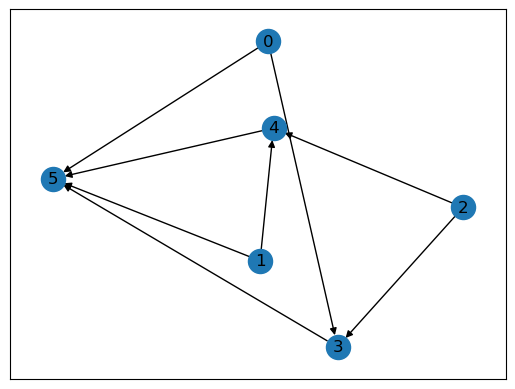

In [15]:
un_iv_adj = np.array([[0,0,0,1,0,1],[0,0,0,0,1,1],[0,0,0,1,1,0],[0,0,0,0,0,1],[0,0,0,0,0,1],[0,0,0,0,0,0]])
un_g = nx.DiGraph(un_iv_adj)
nx.draw_networkx(un_g)
latent = 2
observed = 4
W_of_int = [6,7]


In [16]:
lr = 0.1
w_init = 'cov_guess'
dis = 'Laplace'
s_var = True
lambdas = [0,0.5,1]
moms = [0,0.5, 1]
epochs = 2500
n = 1000

In [17]:
data, params, W_with, w_true = hid_var_data(latent, observed, un_g ,n, distr = dis, same_var = s_var)

In [18]:
loss_data, w_loss_data = graphical_rica(latent, observed, un_g, data, moms, lambdas, epochs, lr, W_with,w_init, w_true) 

 True coefficients : tensor([-14.8581,  -3.0421])
Lambda: 0, Mom: 0, Loss at minimum : tensor([-3.7616, -4.1224], grad_fn=<LogBackward0>)
Lambda: 0.5, Mom: 0, Loss at minimum : tensor([-2.5819,  5.3048], grad_fn=<LogBackward0>)
Lambda: 1, Mom: 0, Loss at minimum : tensor([-2.6922,  5.3380], grad_fn=<LogBackward0>)
Lambda: 0, Mom: 0.5, Loss at minimum : tensor([-3.2926, -3.6465], grad_fn=<LogBackward0>)
Lambda: 0.5, Mom: 0.5, Loss at minimum : tensor([-2.9807,  5.3102], grad_fn=<LogBackward0>)
Lambda: 1, Mom: 0.5, Loss at minimum : tensor([-2.8116,  5.3362], grad_fn=<LogBackward0>)
Lambda: 0, Mom: 1, Loss at minimum : tensor([0.7343, 0.6933], grad_fn=<LogBackward0>)
Lambda: 0.5, Mom: 1, Loss at minimum : tensor([-0.6582,  1.9706], grad_fn=<LogBackward0>)
Lambda: 1, Mom: 1, Loss at minimum : tensor([2.1410, 1.2849], grad_fn=<LogBackward0>)


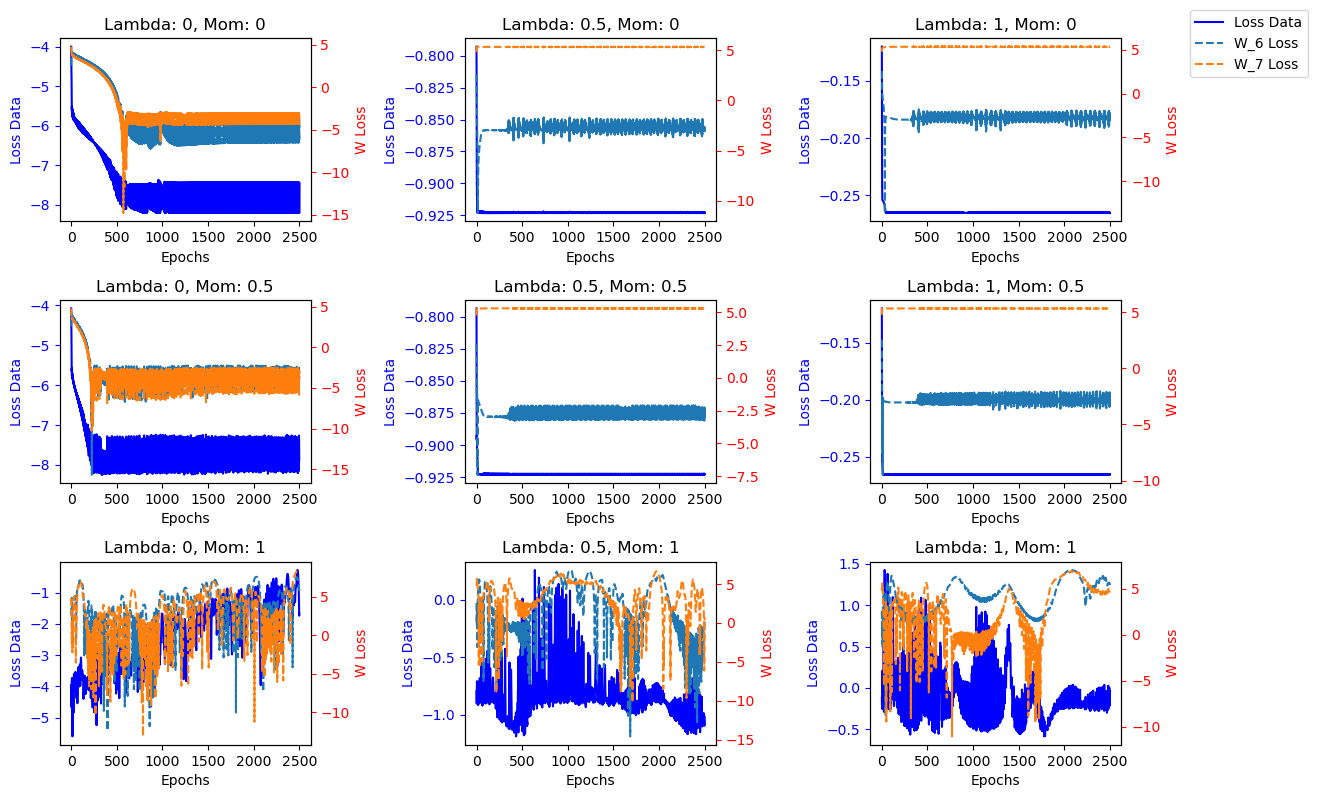

In [19]:
w_of_int = [6,7]
loss_plots(loss_data,  w_loss_data,moms, lambdas, epochs, w_true, w_of_int)

# DiD graph

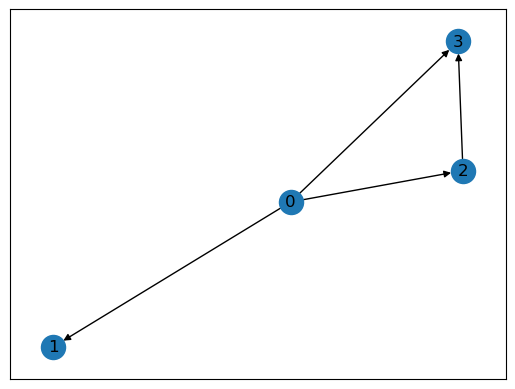

In [20]:
adj_did = np.array([[0,1,1,1],[0,0,0,0],[0,0,0,1],[0,0,0,0]])
g_did = nx.DiGraph(adj_did)
nx.draw_networkx(g_did)
latent = 1
observed = 3

In [21]:
lr = 0.1
w_init = 'cov_guess'
distr = 'Laplace' 
same_var = True
lambdas = [0,0.5,1]
moms = [0,0.5, 1]
epochs = 2500
n = 1000

In [22]:
data, params, W_with, w_true = hid_var_data(latent, observed, g_did ,n, distr = dis, same_var = s_var)

In [23]:
loss_data, w_loss_data = graphical_rica(latent, observed, g_did, data, moms, lambdas, epochs, lr, W_with,w_init, w_true) 

 True coefficients : tensor([-11.4047])
Lambda: 0, Mom: 0, Loss at minimum : tensor([-6.6590], grad_fn=<LogBackward0>)
Lambda: 0.5, Mom: 0, Loss at minimum : tensor([-7.5616], grad_fn=<LogBackward0>)
Lambda: 1, Mom: 0, Loss at minimum : tensor([-6.9465], grad_fn=<LogBackward0>)
Lambda: 0, Mom: 0.5, Loss at minimum : tensor([-7.7763], grad_fn=<LogBackward0>)
Lambda: 0.5, Mom: 0.5, Loss at minimum : tensor([-6.9780], grad_fn=<LogBackward0>)
Lambda: 1, Mom: 0.5, Loss at minimum : tensor([-7.4872], grad_fn=<LogBackward0>)
Lambda: 0, Mom: 1, Loss at minimum : tensor([-0.2799], grad_fn=<LogBackward0>)
Lambda: 0.5, Mom: 1, Loss at minimum : tensor([9.3789], grad_fn=<LogBackward0>)
Lambda: 1, Mom: 1, Loss at minimum : tensor([9.0470], grad_fn=<LogBackward0>)


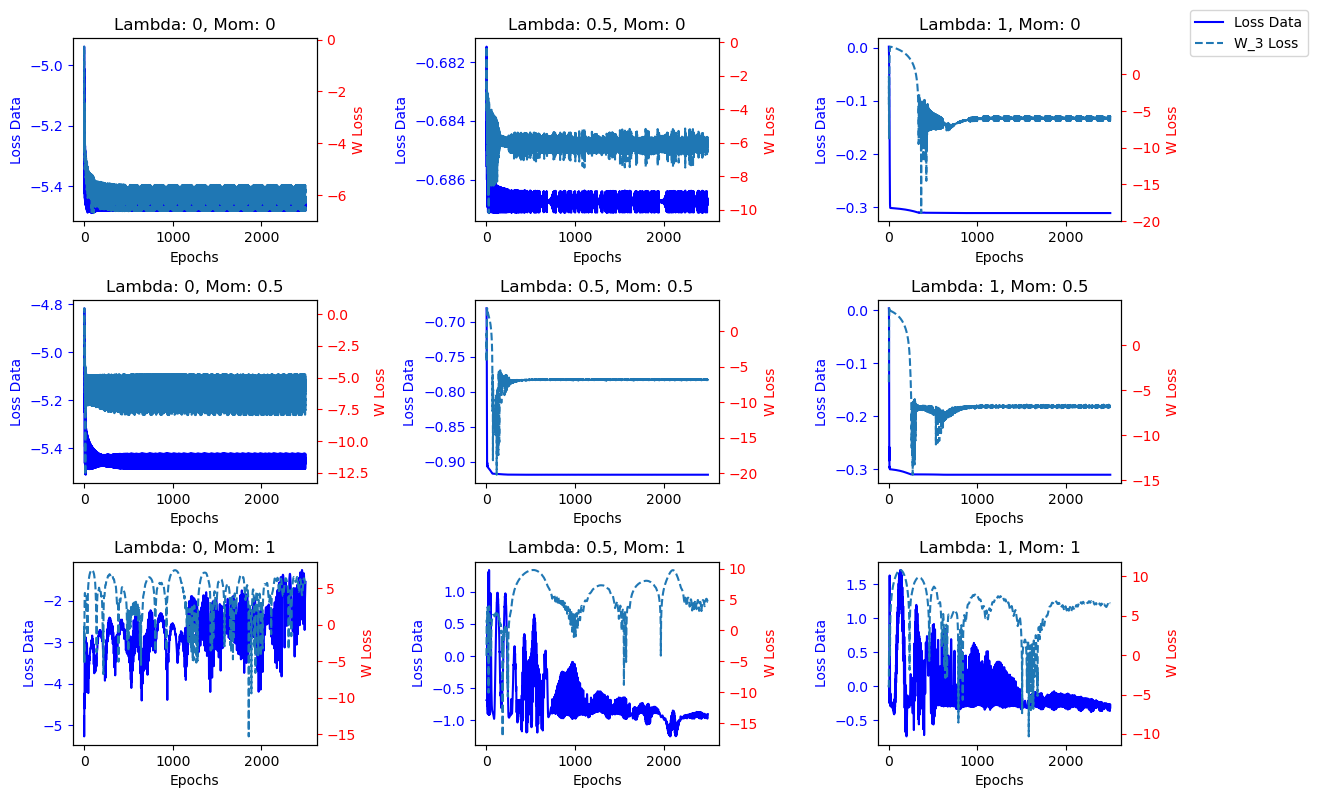

In [24]:
w_of_int = [3]
loss_plots(loss_data,  w_loss_data,moms, lambdas, epochs, w_true, w_of_int)

# New Graph

In [67]:
adj = #np.array([...]) order the graph in such a way that all the hidden nodes come first
g = nx.DiGraph(adj)
nx.draw_networkx(g)
latent = # Number of Latent Variables
observed = # Number of Observed Variables

SyntaxError: invalid syntax (2820093614.py, line 1)

In [68]:
lr = 0.1
w_init = 'cov_guess' # or 'true' or 'random'
distr = 'Laplace' # or 'Cauchy'
same_var = True 
lambdas = [0,0.5,1]
moms = [0,0.5, 1]
epochs = 2500
n = 1000

In [ ]:
data, params, W_with, w_true = hid_var_data(latent, observed, g ,n, distr = dis, same_var = s_var)

In [ ]:
loss_data, w_loss_data = graphical_rica(latent, observed, g_did, data, moms, lambdas, epochs, lr, W_with,w_init, w_true) 

In [ ]:
w_of_int = # causal effects of interest
loss_plots(loss_data,  w_loss_data,moms, lambdas, epochs, w_true, w_of_int)